In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta,date

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import FeatureHasher
from statsmodels.tools.eval_measures import rmse

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Reading the file

In [2]:
final_inv_data = pd.read_csv('/Users/pritigirishvankudre/Capstone Project/data/Final_invoice.csv')

/Users/pritigirishvankudre/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9,10,14,15,21,41,51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
final_inv_data_final = final_inv_data[['Cust Type','Customer No.','District','JobCard Date','KMs Reading','Make','Model','Order Type','Plant','Total Amt Wtd Tax.']].copy()
final_inv_data_final.head()

,Cust Type,Customer No.,District,JobCard Date,KMs Reading,Make,Model,Order Type,Plant,Total Amt Wtd Tax.
0,Retail,67849,Maharashtra,2014-12-13,49317,GENERAL MOTORS,SPARK,Paid Service,BC01,4051.95
1,Retail,84419,Maharashtra,2015-01-02,78584,TATA MOTORS,INDICA,SMC Value Package,BC01,1001.29
2,Retail,81055,Maharashtra,2015-01-02,33985,MARUTI SUZUKI,ZEN,Running Repairs,BC01,233.14
3,Retail,84419,Maharashtra,2015-01-03,78584,TATA MOTORS,INDICA,SMC Redemption,BC01,0.00
4,Retail,18980,Maharashtra,2015-01-02,50057,HYUNDAI,SANTRO XING,Paid Service,BC01,2747.12


In [4]:
final_inv_data_final.dropna(axis = 0,inplace=True)

# Defining Required Functions

In [5]:
'''
Creating attributes of Recency, Frequency and Monetary value along with Mileage
'''
def RFM_feature(data): 
    rec = pd.DataFrame(data.groupby(['Customer No.','District','Model'])
                       ['JobCard Date'].max()).reset_index()
    rec['Recency'] = (rec['JobCard Date'].max() - rec['JobCard Date']).dt.days
    rec.drop('JobCard Date',axis=1,inplace=True)

    freq = pd.DataFrame(data.groupby(['Customer No.','District','Model'])
                        ['JobCard Date'].count()).reset_index()
    freq.columns = ['Customer No.','District','Model','Frequency']

    rev = pd.DataFrame(data.groupby(['Customer No.','District','Model'])
                       ['Total Amt Wtd Tax.'].sum()).reset_index()
    rev.columns = ['Customer No.','District','Model','Revenue']

    km = pd.DataFrame(data.groupby(['Customer No.','District','Model'])
                      ['KMs Reading'].max()).reset_index()
    km.columns = ['Customer No.','District','Model','Mileage']
    
    temp_df = pd.merge(rec,freq,on=['Customer No.','District','Model'])
    temp_df = pd.merge(temp_df,km,on=['Customer No.','District','Model'])
    temp_df = pd.merge(temp_df,rev,on=['Customer No.','District','Model'])
    temp_df.head()
    return temp_df

In [6]:
'''
To identify outliers in the dataset
'''

def get_outliers(self):
        a_list = []
        per_75 = np.percentile(self,75)
        per_25 = np.percentile(self,25)
        iqr = per_75-per_25
        tot_75 = per_75 + (1.5*iqr)
        tot_25 = per_25 - (1.5*iqr)
        a_list1 = np.array(self).tolist()
        for j in a_list1:
            if j > tot_75:
                a_list.append(j)
            if j < tot_25:
                a_list.append(j)
        return a_list

In [7]:
'''
Visualization of outliers for boxplot and distribution plot and understanding the description
'''

def box_plot(data,variable):
    boxplot = data.boxplot(column=[variable])
    plt.show()
    
def dist_plot(data,variable):
    sns.distplot(data[variable])
    plt.axvline(data[variable].mean(), color='r', linestyle='--')
    plt.axvline(data[variable].median(), color='g', linestyle='-')
    plt.show()
    print ('Mean for ',variable,' =',data[variable].mean())
    print ('Median for ',variable,' =',data[variable].median())

In [8]:
'''
Treating for extreme outliers
'''
def outliers_treat(temp_df):
    temp_df=temp_df[temp_df['Customer No.']!='E4981']
    temp_df=temp_df[temp_df['Mileage']<150000]
    temp_df=temp_df[temp_df['Revenue']<1000000]
    return temp_df

In [9]:
'''
Feature engineering with Mileage Feture
'''
def mileage_avg(temp_df):
    temp_df['Mileage']=150000 - temp_df['Mileage']
    return temp_df

In [10]:
'''
Predicting cluster for each of the RFM Feature
'''
def predict_cluster(test_df,target_field):
    km = KMeans(n_clusters=K)
    km.fit(test_df[[target_field]])
    test_df[target_field+'Cluster'] = km.predict(test_df[[target_field]])
    display (test_df.head())
    return test_df

In [11]:
'''
K-means assigns clusters as numbers but not in an ordered way. We can’t say cluster 0 is the worst and cluster 4 
is the best. order_cluster() method does this for us
'''
def order_cluster(cluster_field_name,target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby([cluster_field_name])[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [12]:
'''
Function for getting statistical description for cluster
'''
def stat_desc(df,cluster_field,target_field):
    tx_user = pd.DataFrame(df.groupby([cluster_field])[target_field].count()).reset_index()
    tx_user.columns = [cluster_field,'count']
    tx_user['mean'] = pd.DataFrame(df.groupby([cluster_field])[target_field].mean())
    tx_user['std'] = pd.DataFrame(df.groupby([cluster_field])[target_field].std())
    tx_user['min'] = pd.DataFrame(df.groupby([cluster_field])[target_field].min())
    tx_user['25%'] = pd.DataFrame(df.groupby([cluster_field])[target_field].quantile(q=0.25))
    tx_user['50%'] = pd.DataFrame(df.groupby([cluster_field])[target_field].quantile(q=0.5))
    tx_user['75%'] = pd.DataFrame(df.groupby([cluster_field])[target_field].quantile(q=0.75))
    tx_user['max'] = pd.DataFrame(df.groupby([cluster_field])[target_field].max())
    display (tx_user)

In [13]:
'''
To treat right/positive skewness of the data, applying log transformation method for Frequency and Revenue columns
'''
def log_transform(model_df):    
    model_df['Frequency'] = np.log(model_df['Frequency'])
    model_df['Revenue'] = np.log(model_df['Revenue'] + 1)
    return model_df

In [14]:
'''
Applying OHE to categorical fields
'''
def OHE(model_df):
    model_df = pd.get_dummies(model_df,columns=['District','Model'],drop_first=False)
    return model_df

The feature hashing scheme is another useful feature engineering scheme for dealing with large scale categorical features. In this scheme, a hash function is typically used with the number of encoded features pre-set (as a vector of pre-defined length) such that the hashed values of the features are used as indices in this pre-defined vector and values are updated accordingly. Since a hash function maps a large number of values into a small finite set of values, multiple different values might create the same hash which is termed as collisions. Typically, a signed hash function is used so that the sign of the value obtained from the hash is used as the sign of the value which is stored in the final feature vector at the appropriate index. This should ensure lesser collisions and lesser accumulation of error due to collisions.

Thus even if we have over 1000 distinct categories in a feature and we set b=10 as the final feature vector size, the output feature set will still have only 10 features as compared to 1000 binary features if we used a one-hot encoding scheme.

In [15]:
'''
Applying Feature Hashing Scheme to categorical fields
'''
def hash_feature(model_df):
    fh1 = FeatureHasher(n_features=10, input_type='string')
    fh2 = FeatureHasher(n_features=10, input_type='string')
    hashed_features1 = fh1.fit_transform(model_df['District'])
    hashed_features2 = fh2.fit_transform(model_df['Model'])
    hashed_features1 = pd.DataFrame(hashed_features1.toarray())
    hashed_features2 = pd.DataFrame(hashed_features2.toarray())
    model_df = pd.merge(model_df,hashed_features1,left_index=True,right_index=True)
    model_df = pd.merge(model_df,hashed_features2,left_index=True,right_index=True)
    model_df.drop(['District','Model'],axis=1,inplace=True)
    return model_df

In [16]:
'''
Splitting data into X and Y
'''
def split_data(model_df):
    X = model_df.drop(['Customer No.','Revenue'],axis=1)
    y = model_df['Revenue']
    return (X,y)

In [17]:
'''
Fitting Random Forest Regressor Model
'''
def fit_data(X_train,y_train,model):
    model.fit(X_train,y_train)
    print ('Accuracy of the Model is = ',model.score(X_train,y_train))

In [18]:
'''
Predicting target variable using fitted model
'''
def predict_data(X_test,y_test,model):
    pred = model.predict(X_test)
    print ('Root Mean Square Error for the model is within plus/minus of ',rmse(pred,y_test))

# Loading dataset with required fields

In [19]:
'''
Loading the dataset with required fields from Invoice file dataset
'''
invoice_data = final_inv_data[['Customer No.','District','Model','JobCard Date',
                               'KMs Reading','Order Type','Total Amt Wtd Tax.']].copy()
invoice_data['Customer No.'] = invoice_data['Customer No.'].astype(str)
invoice_data['District'] = invoice_data['District'].astype(str)
invoice_data['Model'] = invoice_data['Model'].astype(str)
invoice_data['JobCard Date'] = pd.to_datetime(invoice_data['JobCard Date'])
invoice_data.head()

,Customer No.,District,Model,JobCard Date,KMs Reading,Order Type,Total Amt Wtd Tax.
0,67849,Maharashtra,SPARK,2014-12-13,49317,Paid Service,4051.95
1,84419,Maharashtra,INDICA,2015-01-02,78584,SMC Value Package,1001.29
2,81055,Maharashtra,ZEN,2015-01-02,33985,Running Repairs,233.14
3,84419,Maharashtra,INDICA,2015-01-03,78584,SMC Redemption,0.00
4,18980,Maharashtra,SANTRO XING,2015-01-02,50057,Paid Service,2747.12


In [20]:
'''
Removing data related to Accidents as that counts to adhoc type of expences which are really difficult to predict
since lot of it's aspect depend on driver's atrribute, road attributes for which we do not have data to accomodate
such features.
'''
final_invoice_data = invoice_data[invoice_data['Order Type']!='Accidental']

In [21]:
'''
Dividing dataset based on period of first 4 years (2012-2015) as training and last 1 year (2016) as test (unseen) data
'''
data_4yr = final_invoice_data[(final_invoice_data['JobCard Date'] > date(2012,1,1)) & 
                              (final_invoice_data['JobCard Date'] <= date(2015,12,31))].reset_index(drop=True)
data_1yr = final_invoice_data[(final_invoice_data['JobCard Date'] > date(2016,1,1)) & 
                              (final_invoice_data['JobCard Date'] <= date(2016,12,31))].reset_index(drop=True)

/Users/pritigirishvankudre/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  after removing the cwd from sys.path.
/Users/pritigirishvankudre/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """
/Users/pritigirishvankudre/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime

# Train the model for data between 2012 to 2015

In [22]:
'''
Creating attributes of Recency, Frequency and Monetary value
'''
temp_df = RFM_feature(data_4yr)

In [23]:
'''
Finding outliers
'''
for i in temp_df[['Recency','Frequency','Mileage','Revenue']]:
    outliers = get_outliers(temp_df[i])
    print ("Total outliers in Column",temp_df[i].name," =",len(outliers))
    print ("Percentatge of outliers in Column",temp_df[i].name," =",
           round(((len(outliers)/temp_df.shape[0])*100),2))
    print ("** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **")

Total outliers in Column Recency  = 0
Percentatge of outliers in Column Recency  = 0.0
** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **
Total outliers in Column Frequency  = 16396
Percentatge of outliers in Column Frequency  = 11.93
** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **
Total outliers in Column Mileage  = 6548
Percentatge of outliers in Column Mileage  = 4.77
** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **
Total outliers in Column Revenue  = 13425
Percentatge of outliers in Column Revenue  = 9.77
** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **


Boxplot visualization for Recency


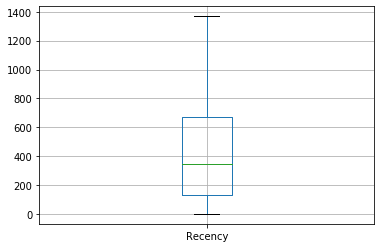

Distribution plot visualization for Recency


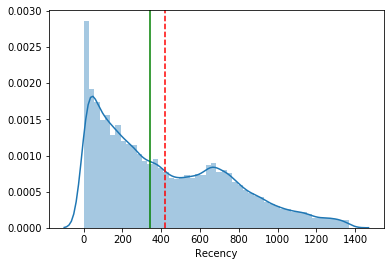

Mean for  Recency  = 421.1494334019898
Median for  Recency  = 344.0
** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **
Boxplot visualization for Frequency


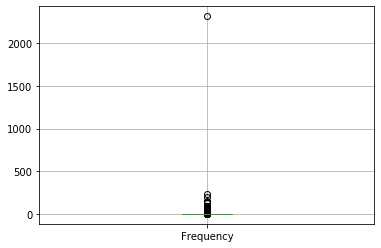

Distribution plot visualization for Frequency


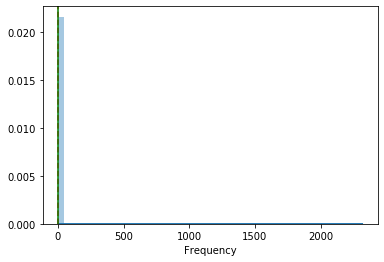

Mean for  Frequency  = 1.9488933689473722
Median for  Frequency  = 1.0
** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **
Boxplot visualization for Mileage


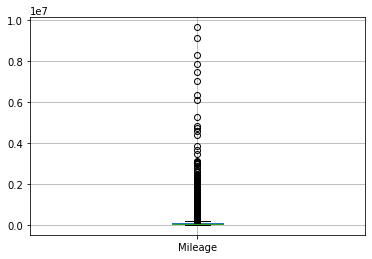

Distribution plot visualization for Mileage


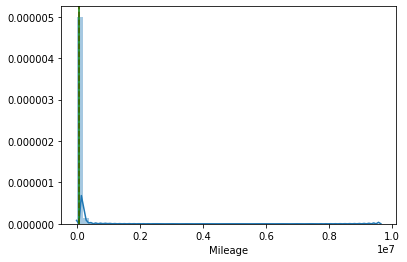

Mean for  Mileage  = 75430.03224186493
Median for  Mileage  = 58349.0
** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **
Boxplot visualization for Revenue


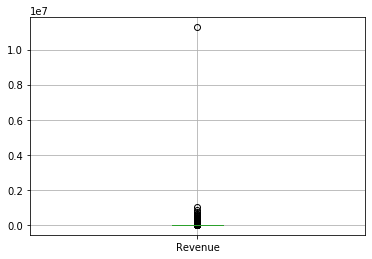

Distribution plot visualization for Revenue


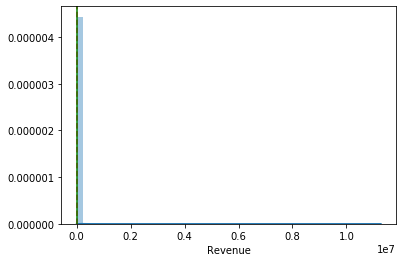

Mean for  Revenue  = 6338.944625288319
Median for  Revenue  = 2382.14
** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **


In [24]:
'''
Visualization of outliers with boxplot and distribution plot and understanding the description
'''

# For Recency
print ('Boxplot visualization for Recency')
box_plot(temp_df,'Recency')
print ('Distribution plot visualization for Recency')
dist_plot(temp_df,'Recency')
print ("** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **")

# For Frequency
print ('Boxplot visualization for Frequency')
box_plot(temp_df,'Frequency')
print ('Distribution plot visualization for Frequency')
dist_plot(temp_df,'Frequency')
print ("** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **")

# For Mileage
print ('Boxplot visualization for Mileage')
box_plot(temp_df,'Mileage')
print ('Distribution plot visualization for Mileage')
dist_plot(temp_df,'Mileage')
print ("** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **")

# For Revenue
print ('Boxplot visualization for Revenue')
box_plot(temp_df,'Revenue')
print ('Distribution plot visualization for Revenue')
dist_plot(temp_df,'Revenue')
print ("** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **")

In [25]:
'''
Treating for extreme outliers
'''
temp_df = outliers_treat(temp_df)

Boxplot visualization for Recency


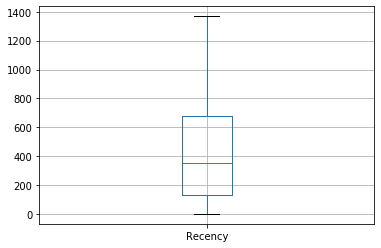

Distribution plot visualization for Recency


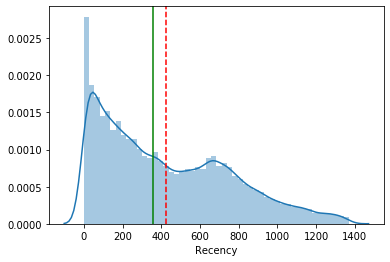

Mean for  Recency  = 426.4189844849686
Median for  Recency  = 355.0
** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **
Boxplot visualization for Frequency


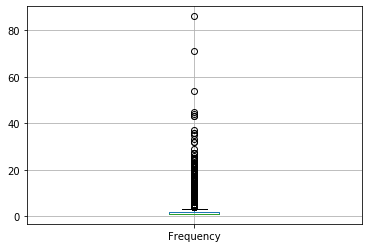

Distribution plot visualization for Frequency


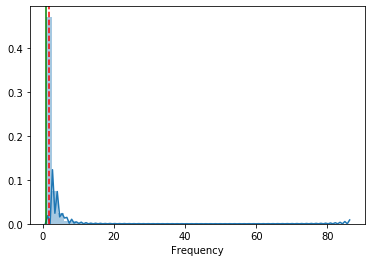

Mean for  Frequency  = 1.8906791856377834
Median for  Frequency  = 1.0
** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **
Boxplot visualization for Mileage


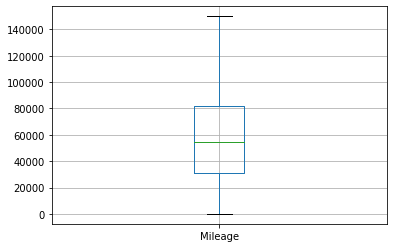

Distribution plot visualization for Mileage


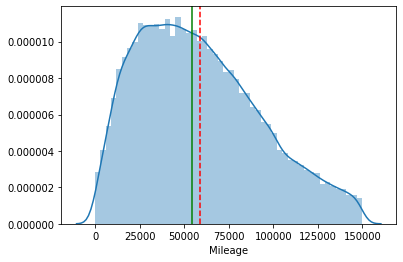

Mean for  Mileage  = 58793.79330329409
Median for  Mileage  = 54467.0
** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **
Boxplot visualization for Revenue


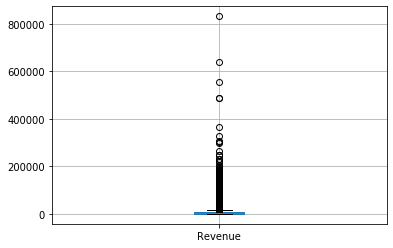

Distribution plot visualization for Revenue


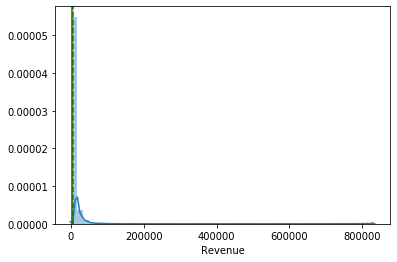

Mean for  Revenue  = 5859.620125347087
Median for  Revenue  = 2364.55
** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **


In [26]:
'''
Visualization of outliers with boxplot and distribution plot and understanding the description
post outlier treatment
'''

# For Recency
print ('Boxplot visualization for Recency')
box_plot(temp_df,'Recency')
print ('Distribution plot visualization for Recency')
dist_plot(temp_df,'Recency')
print ("** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **")

# For Frequency
print ('Boxplot visualization for Frequency')
box_plot(temp_df,'Frequency')
print ('Distribution plot visualization for Frequency')
dist_plot(temp_df,'Frequency')
print ("** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **")

# For Mileage
print ('Boxplot visualization for Mileage')
box_plot(temp_df,'Mileage')
print ('Distribution plot visualization for Mileage')
dist_plot(temp_df,'Mileage')
print ("** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **")

# For Revenue
print ('Boxplot visualization for Revenue')
box_plot(temp_df,'Revenue')
print ('Distribution plot visualization for Revenue')
dist_plot(temp_df,'Revenue')
print ("** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **")

In [27]:
'''
Feature engineering with Mileage Feture
'''
temp_df = mileage_avg(temp_df)

In [28]:
'''
Applying K Means Cluster to find out number of clusters 
So for convenience let’s start by choosing number of iterations as 100.
'''
m=temp_df.shape[0] #number of training examples.
print ("m =",m)
n=temp_df.shape[1] #number of features.
print ("n =",n)
n_iter=100

m = 127167
n = 7


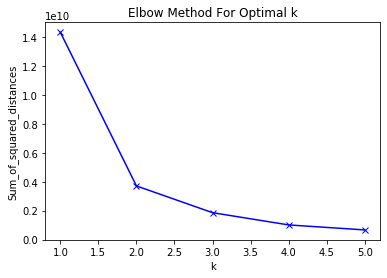

In [29]:
'''
Elbow method to decide on optimal number of clusters
'''

Sum_of_squared_distances = []
K = range(1,6)
for k in K:
    km = KMeans(n_clusters=k, max_iter=n_iter)
    km = km.fit(pd.DataFrame(temp_df['Recency']))
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [30]:
'''
Deciding on optimum value of K
'''
K = 4

In [31]:
'''
Creating Recency Cluster
'''
temp_df = predict_cluster(temp_df,'Recency')
temp_df = order_cluster('RecencyCluster','Recency',temp_df,False)
stat_desc(temp_df,'RecencyCluster','Recency')

,Customer No.,District,Model,Recency,Frequency,Mileage,Revenue,RecencyCluster
0,1,Maharashtra,KIZASHI,1369,1,148788,0.00,2
1,1,Maharashtra,OMNI,1019,3,110025,0.00,2
2,10,Maharashtra,OPTRA,927,5,27176,11105.56,2
3,100,Maharashtra,CITY,1207,1,111424,6632.67,2
4,1000,Maharashtra,ALTO,443,6,130904,8813.44,3


,RecencyCluster,count,mean,std,min,25%,50%,75%,max
0,0,14664,1057.897368,135.159992,875,940.0,1033.0,1154.0,1369
1,1,31878,690.477037,94.029385,528,614.0,686.0,765.0,874
2,2,32789,365.352893,85.135360,232,290.0,360.0,436.0,527
3,3,47836,98.729681,68.613177,0,36.0,92.0,158.0,231


In [32]:
'''
Creating Frequency Cluster
'''
temp_df = predict_cluster(temp_df,'Frequency')
temp_df = order_cluster('FrequencyCluster','Frequency',temp_df,True)
stat_desc(temp_df,'FrequencyCluster','Frequency')

,Customer No.,District,Model,Recency,Frequency,Mileage,Revenue,RecencyCluster,FrequencyCluster
0,1,Maharashtra,KIZASHI,1369,1,148788,0.00,0,0
1,1,Maharashtra,OMNI,1019,3,110025,0.00,0,2
2,10,Maharashtra,OPTRA,927,5,27176,11105.56,0,2
3,100,Maharashtra,CITY,1207,1,111424,6632.67,0,0
4,10002,Maharashtra,OPEL CORSA,1054,1,63831,1828.56,0,0


,FrequencyCluster,count,mean,std,min,25%,50%,75%,max
0,0,101995,1.216481,0.411848,1,1.0,1.0,1.0,2
1,1,19674,3.643031,0.761833,3,3.0,3.0,4.0,5
2,2,5103,7.454439,1.635022,6,6.0,7.0,8.0,12
3,3,395,16.820253,6.870122,13,13.0,15.0,17.0,86


In [33]:
'''
Creating Revenue Cluster
'''
temp_df = predict_cluster(temp_df,'Revenue')
temp_df = order_cluster('RevenueCluster','Revenue',temp_df,True)
stat_desc(temp_df,'RevenueCluster','Revenue')

,Customer No.,District,Model,Recency,Frequency,Mileage,Revenue,RecencyCluster,FrequencyCluster,RevenueCluster
0,1,Maharashtra,KIZASHI,1369,1,148788,0.00,0,0,0
1,100,Maharashtra,CITY,1207,1,111424,6632.67,0,0,0
2,10002,Maharashtra,OPEL CORSA,1054,1,63831,1828.56,0,0,0
3,10004,Maharashtra,GETZ,1054,1,134876,750.30,0,0,0
4,10005,Maharashtra,CITY,1054,1,107472,1745.01,0,0,0


,RevenueCluster,count,mean,std,min,25%,50%,75%,max
0,0,109218,2736.286244,2848.113086,0.00,448.2800,1706.155,4202.3825,11400.86
1,1,16189,20045.543801,7617.515620,11401.14,13969.3300,17697.730,24172.2600,43159.98
2,2,1742,66168.740293,25810.367656,43173.29,48307.0725,56981.280,74775.5675,206609.16
3,3,18,361963.741111,171910.532101,217503.35,247846.3050,299656.630,456634.0675,832669.42


In [34]:
'''
Creating Mileage Cluster
'''
temp_df = predict_cluster(temp_df,'Mileage')
temp_df = order_cluster('MileageCluster','Mileage',temp_df,True)
stat_desc(temp_df,'MileageCluster','Mileage')

,Customer No.,District,Model,Recency,Frequency,Mileage,Revenue,RecencyCluster,FrequencyCluster,RevenueCluster,MileageCluster
0,1,Maharashtra,KIZASHI,1369,1,148788,0.00,0,0,0,0
1,100,Maharashtra,CITY,1207,1,111424,6632.67,0,0,0,2
2,10002,Maharashtra,OPEL CORSA,1054,1,63831,1828.56,0,0,0,1
3,10004,Maharashtra,GETZ,1054,1,134876,750.30,0,0,0,0
4,10005,Maharashtra,CITY,1054,1,107472,1745.01,0,0,0,2


,MileageCluster,count,mean,std,min,25%,50%,75%,max
0,0,15523,27867.086195,13164.278207,1,17609.00,29750.0,39240.5,47335
1,1,31524,66936.444170,9959.335144,47337,58805.75,67869.0,75557.0,82522
2,2,40849,98275.897378,8780.900425,82524,90714.00,98463.0,105843.0,113263
3,3,39271,128371.121438,9519.977897,113264,120288.00,127450.0,135694.0,150000


In [35]:
'''
Calculating Overall score
'''
temp_df['OverallScore'] = temp_df['RecencyCluster'] + temp_df['FrequencyCluster'] + temp_df['RevenueCluster'] + temp_df['MileageCluster']
display (temp_df.head())
display(temp_df.groupby('OverallScore')['Recency','Frequency','Revenue','Mileage'].mean())

,Customer No.,District,Model,Recency,Frequency,Mileage,Revenue,RecencyCluster,FrequencyCluster,RevenueCluster,MileageCluster,OverallScore
0,1,Maharashtra,KIZASHI,1369,1,148788,0.00,0,0,0,3,3
1,10004,Maharashtra,GETZ,1054,1,134876,750.30,0,0,0,3,3
2,10006,Maharashtra,I20,1054,1,132157,2727.45,0,0,0,3,3
3,10008,Maharashtra,BEAT,1054,1,142223,1128.24,0,0,0,3,3
4,10038,Maharashtra,I20,1053,1,116621,599.90,0,0,0,3,3


,Recency,Frequency,Revenue,Mileage
OverallScore,,,,
0,1054.541302,1.164237,2622.297561,29020.525753
1,899.523513,1.219199,3209.644157,49041.849592
2,760.237760,1.286937,3556.109534,67599.733735
3,586.823151,1.372932,3791.286288,80377.459776
4,421.157650,1.544755,4625.223450,93613.585076
5,254.441518,1.860612,5834.194675,102651.502943
6,151.139051,2.334768,7252.079351,114428.215333
7,142.760801,5.001189,17806.737679,103497.228894
8,117.422117,7.582045,28554.968585,101070.771700


In [36]:
temp_df.to_csv('/Users/pritigirishvankudre/Capstone Project/data/jainam_cluster.csv')

In [37]:
'''
Selecting only required RFM features for model building
'''
model_df = temp_df.iloc[:,0:7]

In [38]:
'''
Understanding skewness of data before applying any skewness correction treatment
'''
model_df.skew(axis=0)

Recency       0.640613
Frequency     5.440516
Mileage      -0.516503
Revenue      11.826165
dtype: float64

In [39]:
'''
To treat right/positive skewness of the data, applying log transformation method for Frequency and Revenue columns
'''
model_df = log_transform(model_df)

In [40]:
'''
Skewness of data post applying correcting measures
'''
model_df.skew(axis=0)

Recency      0.640613
Frequency    1.341952
Mileage     -0.516503
Revenue     -1.572178
dtype: float64

Distribution plot visualization for Frequency


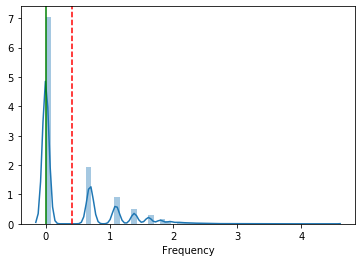

Mean for  Frequency  = 0.40555423523388395
Median for  Frequency  = 0.0
** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **
Distribution plot visualization for Mileage


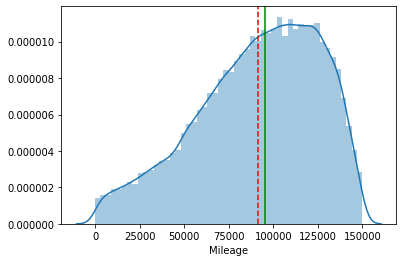

Mean for  Mileage  = 91206.2066967059
Median for  Mileage  = 95533.0
** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **
Distribution plot visualization for Revenue


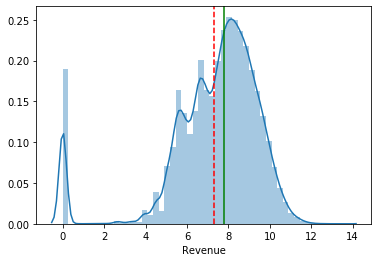

Mean for  Revenue  = 7.3279115137599256
Median for  Revenue  = 7.768765832028116
** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **


In [41]:
'''
Visualization of distribution plot post skewness correction
'''

# For Frequency
print ('Distribution plot visualization for Frequency')
dist_plot(model_df,'Frequency')
print ("** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **")

# For Mileage
print ('Distribution plot visualization for Mileage')
dist_plot(model_df,'Mileage')
print ("** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **")

# For Revenue
print ('Distribution plot visualization for Revenue')
dist_plot(model_df,'Revenue')
print ("** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **")

In [42]:
'''
Applying OHE to categorical fields
'''
#model_df = OHE(model_df)

'\nApplying OHE to categorical fields\n'

In [43]:
'''
Applying Feature Hashing Scheme to categorical fields
'''
model_df = hash_feature(model_df)

In [44]:
'''
Splitting data into X and Y
'''
X,y = split_data(model_df)

In [45]:
'''
Creating Train and Test sample to fit and predict using Random Forest Regressor model
'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [46]:
'''
Defining the model
'''
model = RandomForestRegressor(n_estimators=100)

In [47]:
'''
Fitting Random Forest Regressor Model
'''
fit_data(X_train,y_train,model)

Accuracy of the Model is =  0.8906149441960943


In [48]:
'''
Predicting target variable using fitted model
'''
predict_data(X_test,y_test,model)

Root Mean Square Error for the model is within plus/minus of  2.0210396151655448


# Testing model on 2016 data

In [49]:
'''
Creating attributes of Recency, Frequency and Monetary value
'''
temp_df_test = RFM_feature(data_1yr)

In [50]:
'''
Treating for extreme outliers
'''
temp_df_test = outliers_treat(temp_df_test)

In [51]:
'''
Feature engineering with Mileage Feture
'''
temp_df_test = mileage_avg(temp_df_test)

In [52]:
'''
Selecting only required RFM features for model building
'''
model_df_test = temp_df_test.iloc[:,0:7]

In [53]:
'''
Understanding skewness of data before applying any skewness correction treatment
'''
model_df_test.skew(axis=0)

Recency       0.435585
Frequency    12.844593
Mileage      -0.443139
Revenue      18.271441
dtype: float64

In [54]:
'''
To treat right/positive skewness of the data, applying log transformation method for Frequency and Revenue columns
'''
model_df_test = log_transform(model_df_test)

In [55]:
'''
Skewness of data post applying correcting measures
'''
model_df_test.skew(axis=0)

Recency      0.435585
Frequency    1.801139
Mileage     -0.443139
Revenue     -1.326058
dtype: float64

In [56]:
'''
Applying Feature Hashing Scheme to categorical fields
'''
model_df_test = hash_feature(model_df_test)

In [57]:
'''
Splitting data into X and Y
'''
X,y = split_data(model_df_test)

In [58]:
'''
Predicting target variable using fitted model
'''
predict_data(X,y,model)

Root Mean Square Error for the model is within plus/minus of  2.6118631043470377
